In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error


from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse
import numpy as np

from datetime import datetime



In [2]:
df = pd.read_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/time_series_dataframe.csv', index_col=1,parse_dates=True)

In [3]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

In [4]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)

In [5]:
df.index=pd.to_datetime(df.index)

In [6]:
df.head()

,CS_HPA_20_cities,CS_HP,UNEMPLOY,LF_Part,Y10_CMT,Y30_fixed_mortgage_rate,UNEMPLOY_adj,LF_Part_adj,year,month
Date,,,,,,,,,,
2000-01-01,100.589697,100.552,4.5,67.3,6.661000,8.2100,4.5,67.3,2000,Jan
2000-02-01,101.692479,101.339,4.4,67.3,6.519500,8.3250,4.4,67.3,2000,Feb
2000-03-01,102.783829,102.127,4.3,67.3,6.256522,8.2400,4.3,67.3,2000,Mar
2000-04-01,103.996444,102.922,3.7,67.3,5.990526,8.1525,3.7,67.3,2000,Apr
2000-05-01,105.252818,103.677,3.8,67.1,6.440455,8.5150,3.8,67.1,2000,May


In [7]:
target_index ='CS_HP'

In [8]:
index_title ='Case Shiller Housing Price Index'

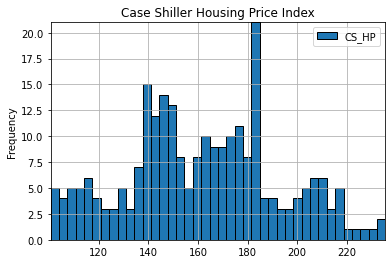

In [9]:
df.plot.hist(y=target_index,grid=True,bins=40,edgecolor='k',title=index_title).autoscale(enable=True,axis='both',tight=True)
plt.show()

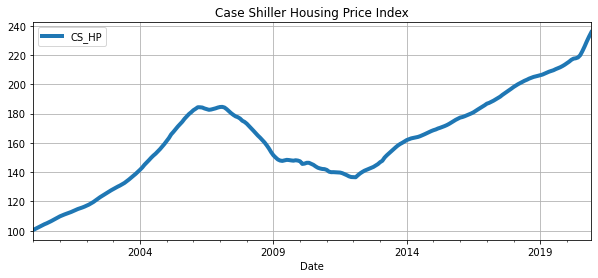

In [10]:
df.plot.line(y=target_index, figsize=(10,4),lw=4, grid=True, title=index_title)
plt.show()

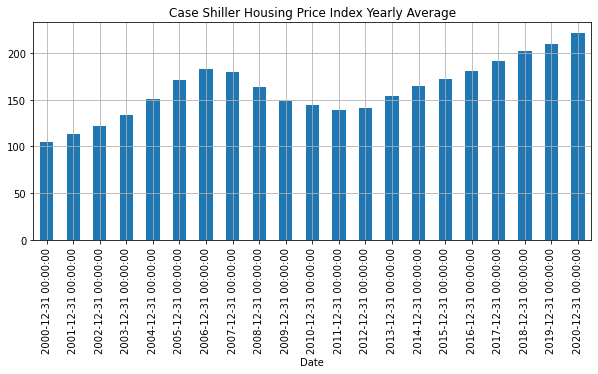

In [11]:
df[target_index].resample('A').mean().plot.bar(figsize=(10,4),grid=True, title=index_title + ' Yearly Average')
plt.show()

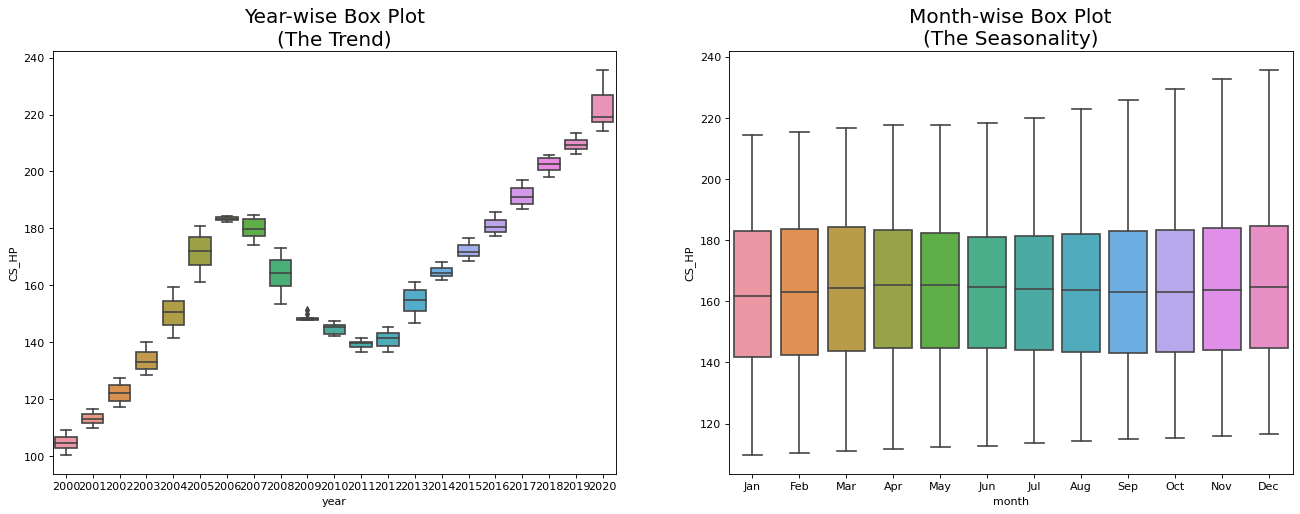

In [12]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y=target_index, data=df, ax=axes[0])
sns.boxplot(x='month', y=target_index, data=df.loc[~df.year.isin([2000]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

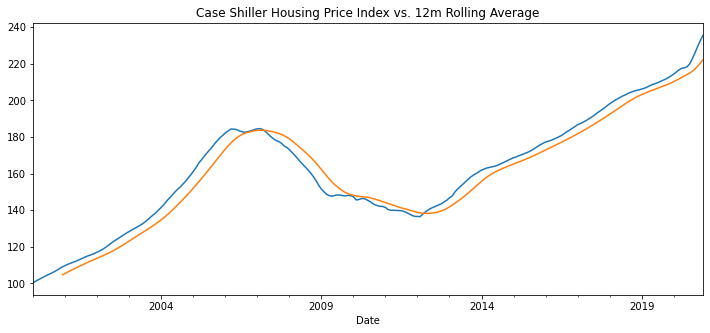

In [13]:
df[target_index].plot(figsize=(12,5))
df[target_index].rolling(window=12).mean().plot(title=index_title + ' vs. 12m Rolling Average')
plt.show()

In [14]:
cycle, trend = hpfilter(df[target_index], lamb=129600)

In [15]:
df['Trend']=trend

In [16]:
df['Cycle']=cycle

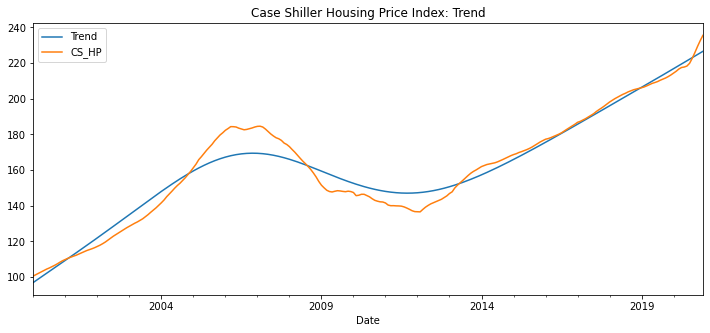

In [17]:
df[['Trend',target_index]].plot(figsize=(12,5),title=index_title + ': Trend')
plt.show()

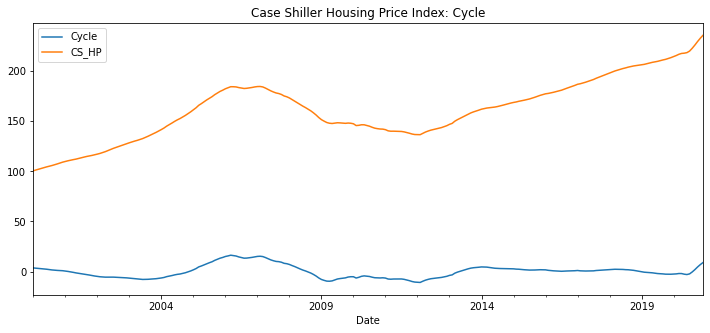

In [18]:
df[['Cycle',target_index]].plot(figsize=(12,5),title=index_title + ': Cycle')
plt.show()

In [19]:
#ETS

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,12

In [21]:
result_additive = seasonal_decompose(df[target_index], model = 'additive')

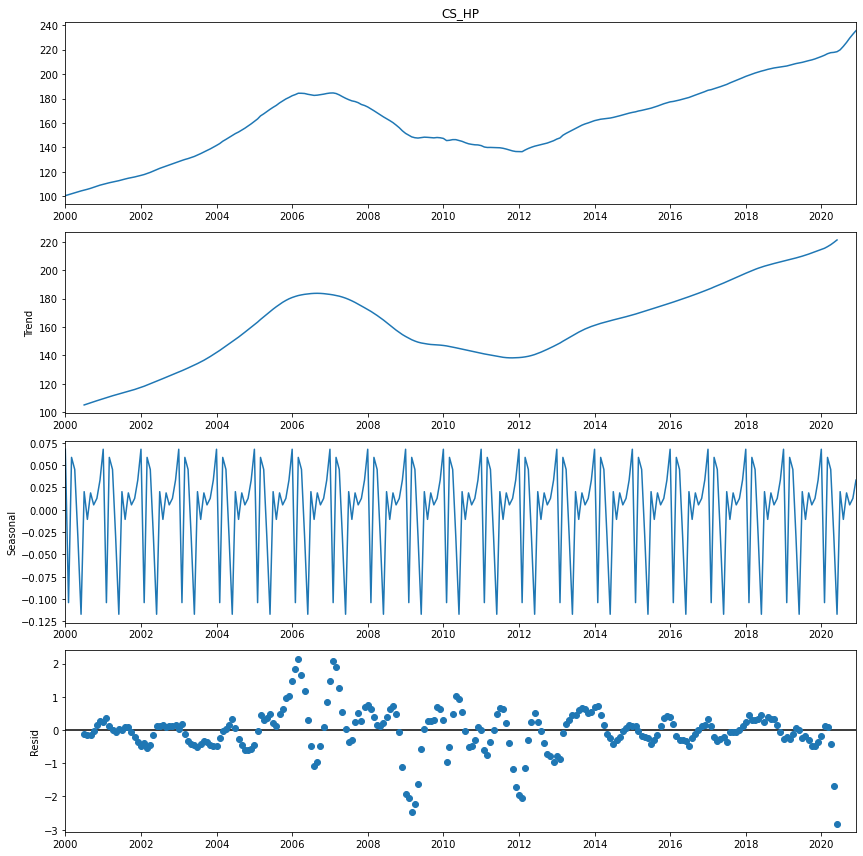

In [22]:
result_additive.plot();

In [23]:
result_multiplicative = seasonal_decompose(df[target_index], model = 'multiplicative')

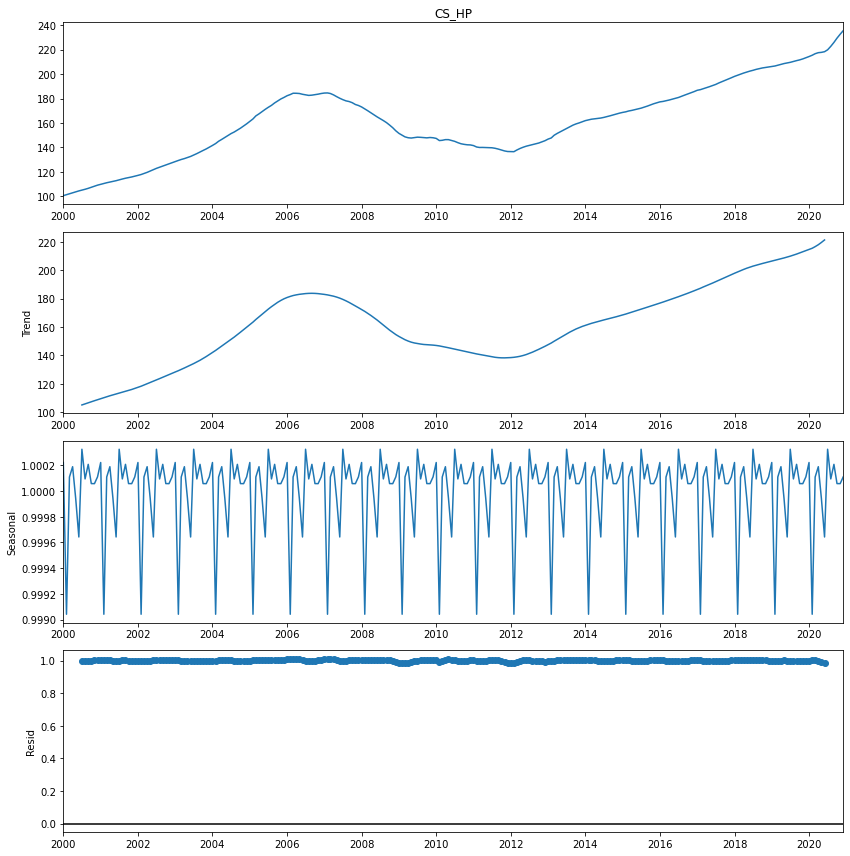

In [24]:
result_multiplicative.plot();

In [25]:
#EWMA

In [26]:
df['6-month--SMA']=df[target_index].rolling(window=6).mean()

In [27]:
df['12-month--SMA']=df[target_index].rolling(window=12).mean()

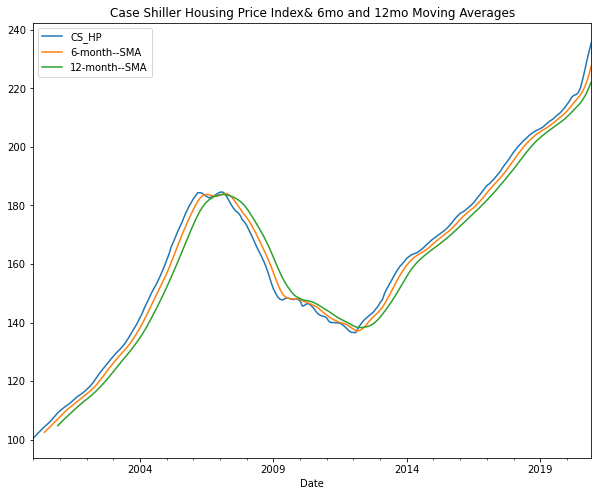

In [28]:
df[[target_index,'6-month--SMA','12-month--SMA']].plot(figsize=(10,8),title=index_title + '& 6mo and 12mo Moving Averages')
plt.show()

In [29]:
df['EWMA-12']=df[target_index].ewm(span=12, adjust=True).mean()

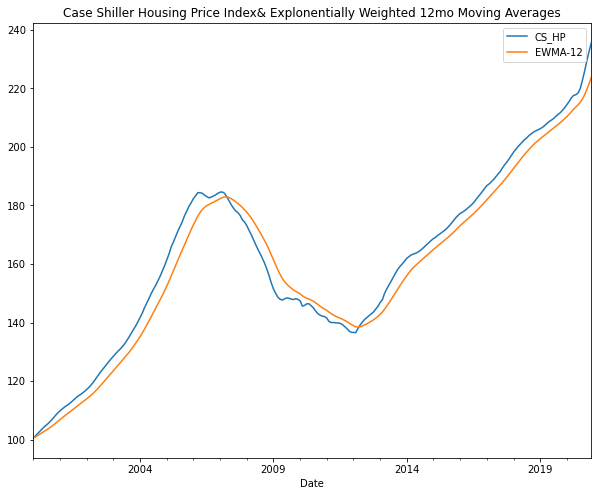

In [30]:
df[[target_index,'EWMA-12']].plot(figsize=(10,8),title=index_title + '& Explonentially Weighted 12mo Moving Averages')
plt.show()

In [31]:
#Holt-Winters method

In [32]:
df.index.freq= 'MS'

In [33]:
span = 12
alpha = 2/(span+1)

In [34]:
model = SimpleExpSmoothing(df[target_index])

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [35]:
fitted_model=model.fit(smoothing_level=alpha, optimized = False)

In [36]:
df['SES12']=fitted_model.fittedvalues.shift(-1)

In [37]:
model =  ExponentialSmoothing(df[target_index],trend='add')

In [38]:
fitted_model = model.fit()

In [39]:
df['DES_add_12']=fitted_model.fittedvalues.shift(-1)

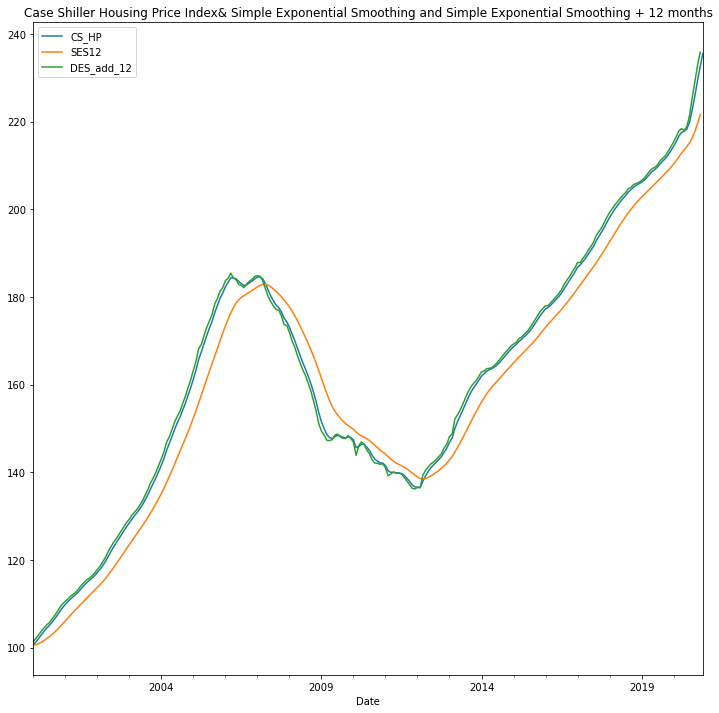

In [40]:
df[[target_index, 'SES12','DES_add_12']].plot(title=index_title + '& Simple Exponential Smoothing and Simple Exponential Smoothing + 12 months')
plt.show()

In [41]:
model =  ExponentialSmoothing(df[target_index],trend='add',seasonal='add', seasonal_periods=12)

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [42]:
fitted_model = model.fit()

In [43]:
df['TES_mul_12']=fitted_model.fittedvalues.shift(-1)

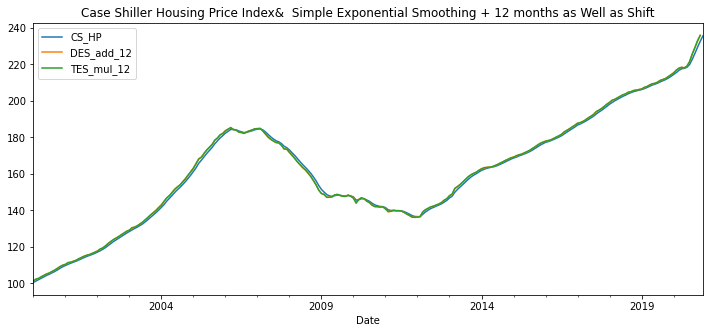

In [44]:
df[[target_index,'DES_add_12','TES_mul_12']].plot(figsize=(12,5),title=index_title + '&  Simple Exponential Smoothing + 12 months as Well as Shift')
plt.show()

In [45]:
df.drop(labels=['Trend','Cycle','6-month--SMA','12-month--SMA','EWMA-12','SES12','DES_add_12','TES_mul_12'],axis=1, inplace=True)

In [46]:
train_data=df.iloc[:201]
test_data=df.iloc[200:]

In [47]:
fitted_model=ExponentialSmoothing(train_data[target_index],
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12).fit()

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [48]:
test_predictions=fitted_model.forecast(52)

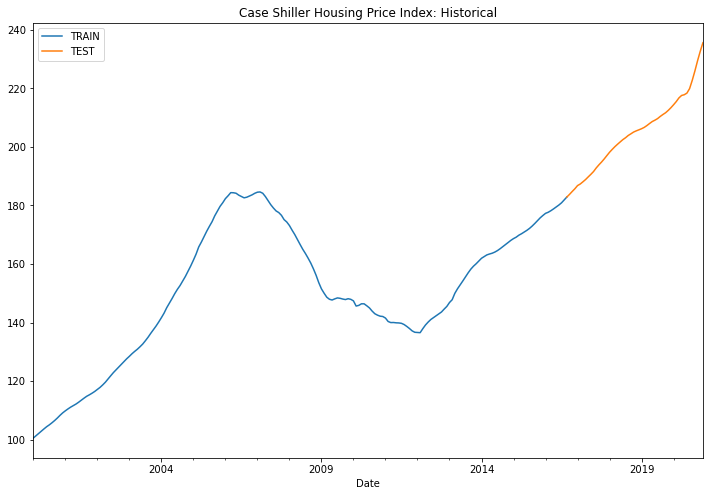

In [49]:
train_data[target_index].plot(legend=True, label='TRAIN', figsize=(12,8),title=index_title + ': Historical')
test_data[target_index].plot(legend=True, label='TEST')
plt.show()

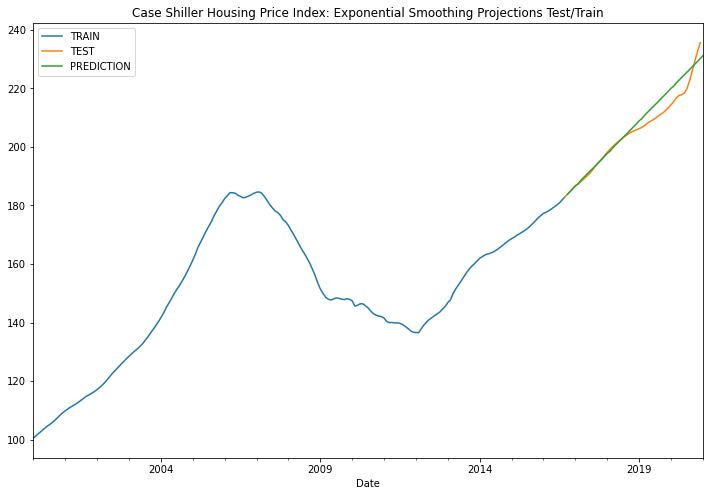

In [50]:
train_data[target_index].plot(legend=True, label='TRAIN', figsize=(12,8),title=index_title + ': Exponential Smoothing Projections Test/Train')
test_data[target_index].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='PREDICTION')
plt.show()

In [51]:
## Evaulation

In [52]:
mean_absolute_error(test_data[target_index],test_predictions)

2.9978829086160985

In [53]:
mean_squared_error(test_data[target_index],test_predictions)

14.398414008190024

In [54]:
np.sqrt(mean_squared_error(test_data[target_index],test_predictions))

3.794524213678182

In [55]:
final_model=ExponentialSmoothing(df[target_index], 
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12).fit()

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [56]:
forecast_predictions=final_model.forecast(36)

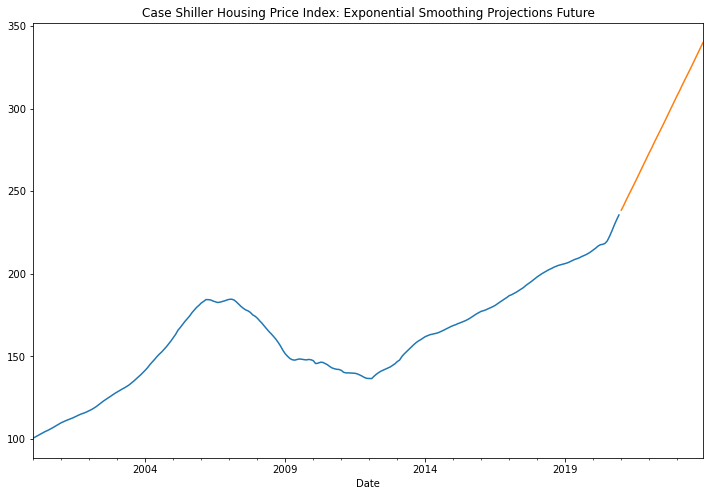

In [57]:
df[target_index].plot(figsize=(12,8),title=index_title + ': Exponential Smoothing Projections Future')
forecast_predictions.plot()
plt.show()

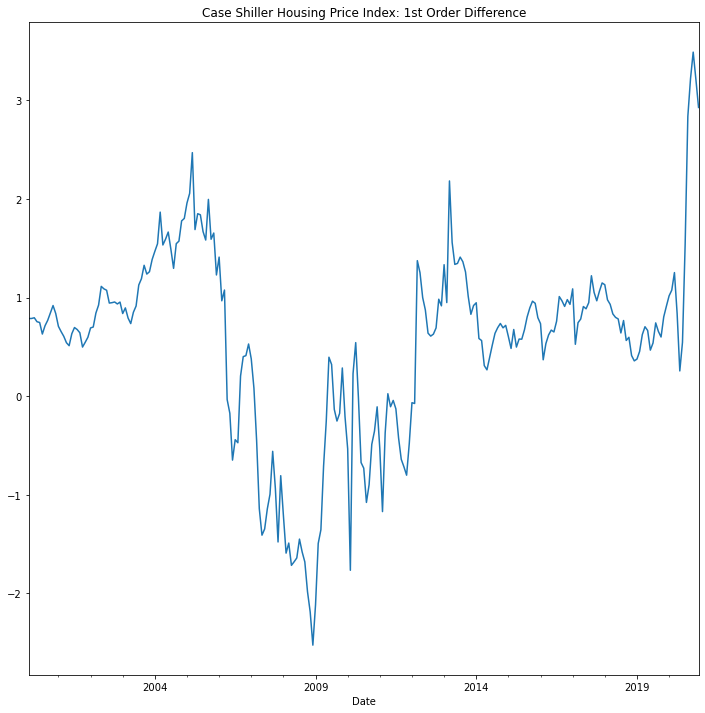

In [58]:
diff(df[target_index],k_diff=1).plot(title=index_title + ': 1st Order Difference')
plt.show()

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
#acf(df[target_index])

In [61]:
#pacf_yw(df[target_index], nlags=252, method='mle')

In [62]:
#pacf_ols(df[target_index], nlags=251)

In [63]:
from pandas.plotting import lag_plot

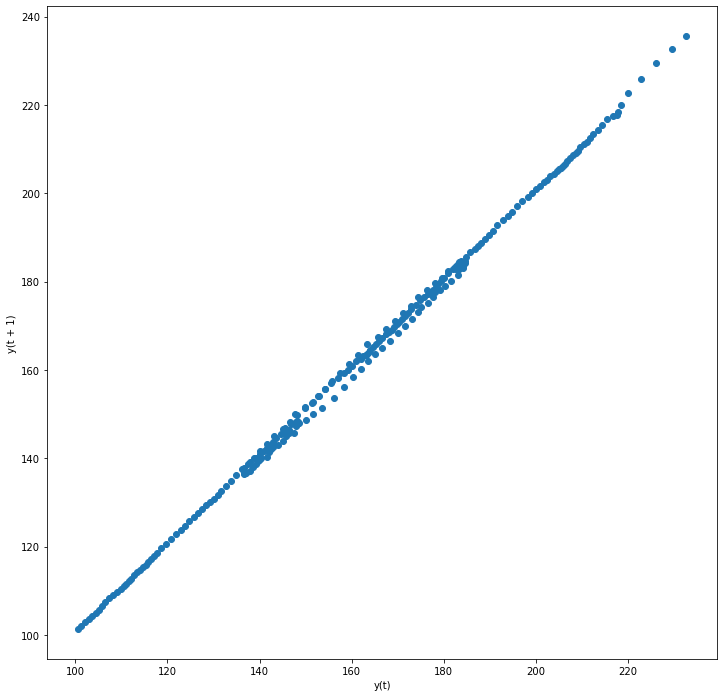

In [64]:
lag_plot(df[target_index])
plt.show()

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

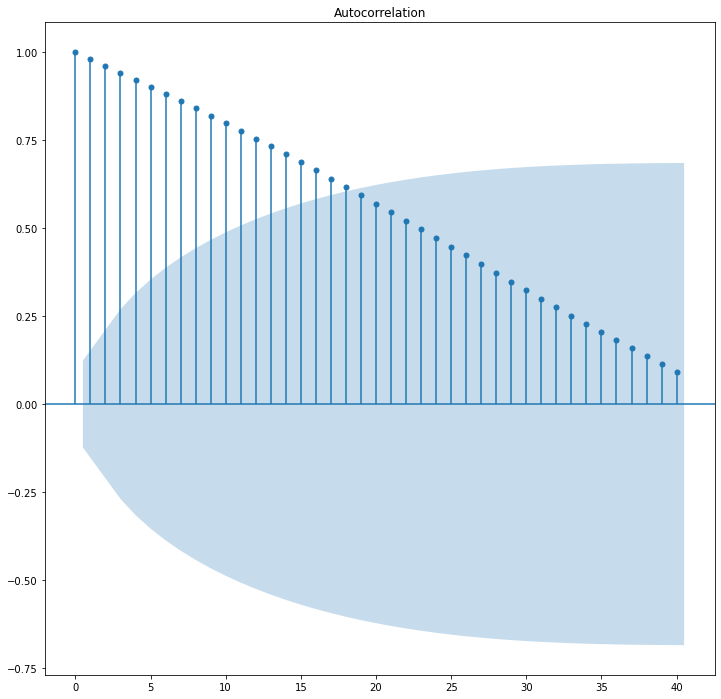

In [66]:
plot_acf(df[target_index],lags=40)
plt.show()

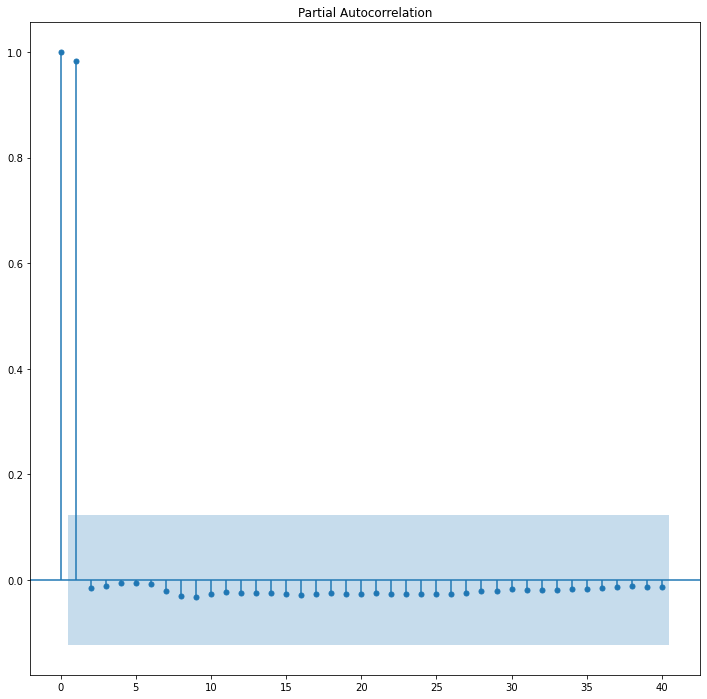

In [67]:
plot_pacf(df[target_index],lags=40)
plt.show()

In [68]:
#AR model

In [69]:
from statsmodels.tsa.ar_model import AR, ARResults

In [70]:
train =df.iloc[:200]

In [71]:
test =df.iloc[200:]

In [72]:
model = AR(train[target_index])

In [73]:
AR1fit = model.fit(maxlag=1)

In [74]:
AR1fit.aic

-0.037635107085314805

In [75]:
AR1fit.k_ar

1

In [76]:
AR1fit.params

const       1.628410
L1.CS_HP    0.991887
dtype: float64

In [77]:
start=len(train)

In [78]:
end=len(train)+len(test)-1

In [79]:
#AR1fit.predict(start=start, end=end)

In [80]:
predictions1 = AR1fit.predict(start=start, end=end)

In [81]:
predictions1 = predictions1.rename('AR{1} Predictions')

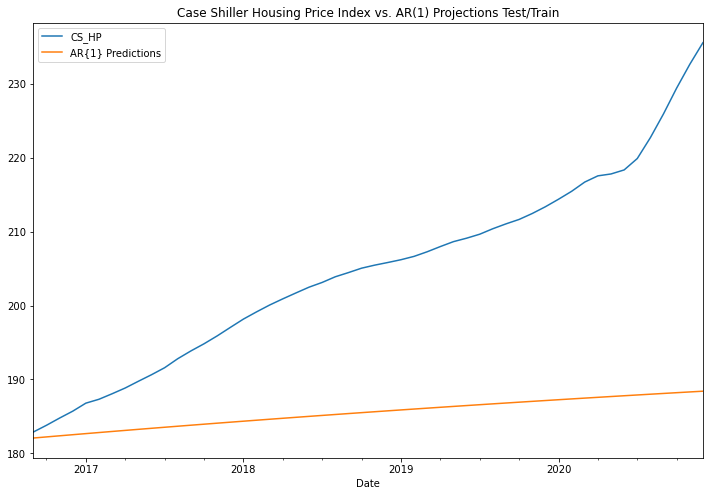

In [82]:
test[target_index].plot(figsize=(12,8),legend=True, title=index_title + ' vs. AR(1) Projections Test/Train')
predictions1.plot(legend=True);

In [83]:
model = AR(train[target_index])

In [84]:
AR2fit = model.fit(maxlag=2)

In [85]:
AR2fit.params

const       0.323373
L1.CS_HP    1.930500
L2.CS_HP   -0.932459
dtype: float64

In [86]:
predictions2 = AR2fit.predict(start=start, end=end)

In [87]:
predictions2 = predictions2.rename('AR{2} Predictions')

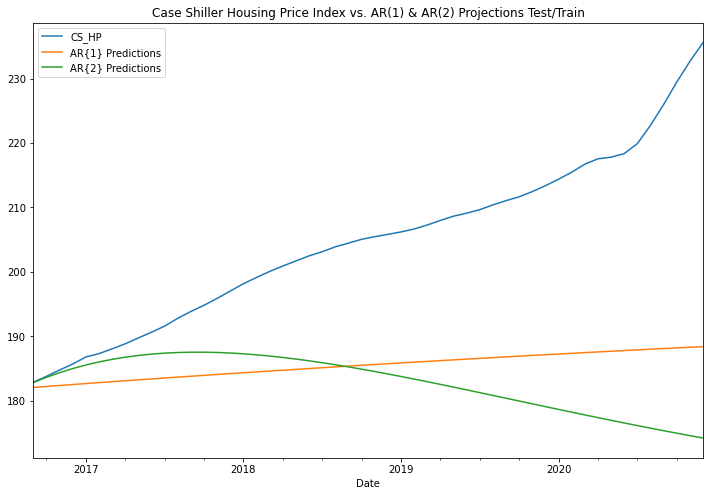

In [88]:
test[target_index].plot(figsize=(12,8),legend=True,title=index_title + ' vs. AR(1) & AR(2) Projections Test/Train')
predictions1.plot(legend=True)
predictions2.plot(legend=True);

In [89]:
model = AR(train[target_index])

In [90]:
ARfit = model.fit(ic='t-stat')

In [91]:
ARfit.params

const        0.440102
L1.CS_HP     1.888447
L2.CS_HP    -0.849895
L3.CS_HP    -0.186310
L4.CS_HP     0.306182
L5.CS_HP    -0.253754
L6.CS_HP     0.178437
L7.CS_HP    -0.181229
L8.CS_HP     0.115642
L9.CS_HP     0.166176
L10.CS_HP   -0.298240
L11.CS_HP    0.111144
L12.CS_HP    0.335721
L13.CS_HP   -0.665820
L14.CS_HP    0.330780
dtype: float64

In [92]:
predictions14=ARfit.predict(start,end)

In [93]:
predictions14=predictions14.rename('AR(14) Predictions')

In [94]:
from sklearn.metrics import mean_squared_error

In [95]:
labels = ['AR1','AR2','AR14']

In [96]:
preds = [predictions1,predictions2,predictions14]

In [97]:
for i in range(3):
    error = np.sqrt(mean_squared_error(test[target_index], preds[i]))
    print(f' {labels[i]} RMSE was: {error}')

 AR1 RMSE was: 22.22418296138832
 AR2 RMSE was: 27.53365598102823
 AR14 RMSE was: 32.635900553296736


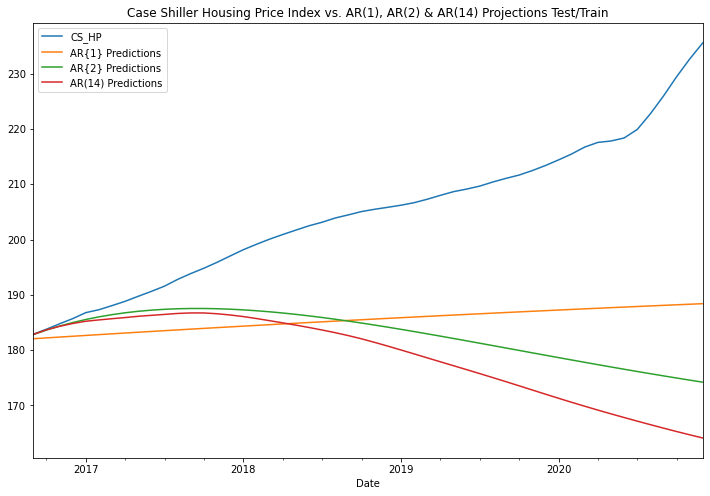

In [98]:
test[target_index].plot(figsize=(12,8),legend=True,title=index_title + ' vs. AR(1), AR(2) & AR(14) Projections Test/Train')
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions14.plot(legend=True);

In [99]:
#Forecasting

In [100]:
model=AR(df[target_index])

In [101]:
ARfit = model.fit(maxlag=14)

In [102]:
forcasted_values=ARfit.predict(start=len(df), end= len(df)+36).rename('Forecast')

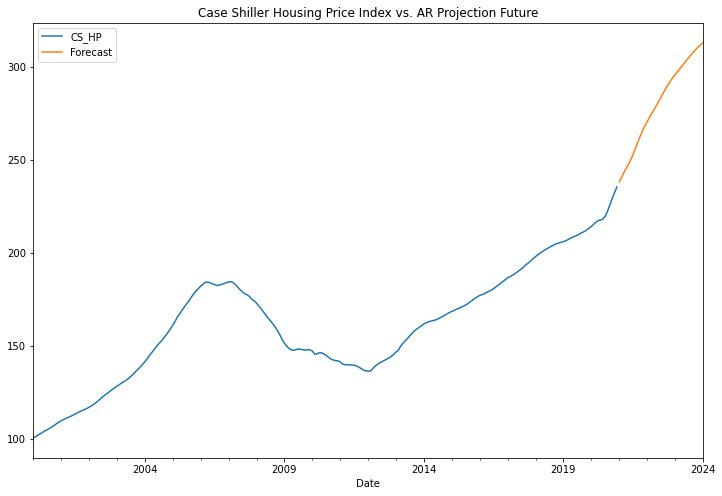

In [103]:
df[target_index].plot(figsize=(12,8), legend=True,title=index_title + ' vs. AR Projection Future')
forcasted_values.plot(legend=True)
plt.show()

In [104]:
#Descriptive statistics and tests

In [105]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

In [106]:
dftest=adfuller(df[target_index])
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

In [107]:
for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

ADF test statistic        0.034302
p-value                   0.961279
# lags used              14.000000
# observations          237.000000
critical value (1%)      -3.458247
critical value (5%)      -2.873814
critical value (10%)     -2.573311
dtype: float64


In [108]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [109]:
adf_test(df[target_index])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.034302
p-value                   0.961279
# lags used              14.000000
# observations          237.000000
critical value (1%)      -3.458247
critical value (5%)      -2.873814
critical value (10%)     -2.573311
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


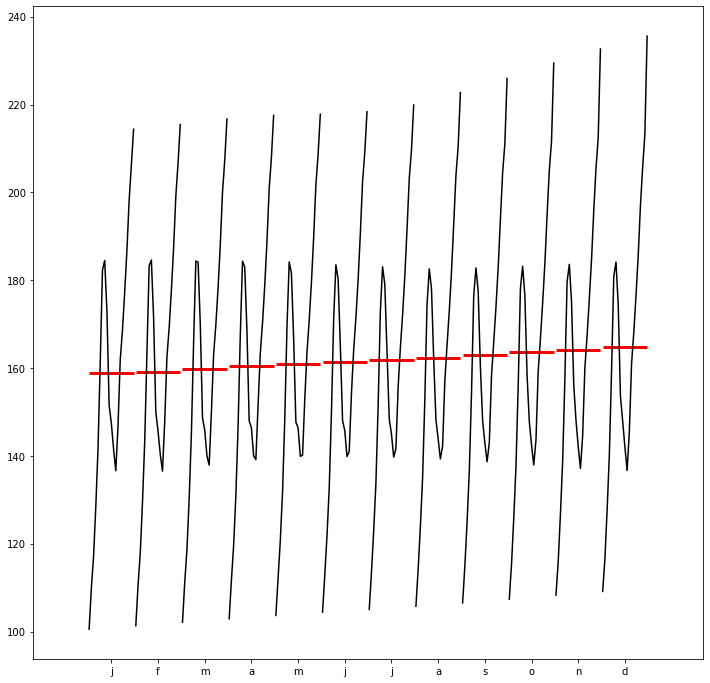

In [110]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
month_plot(df[target_index]);

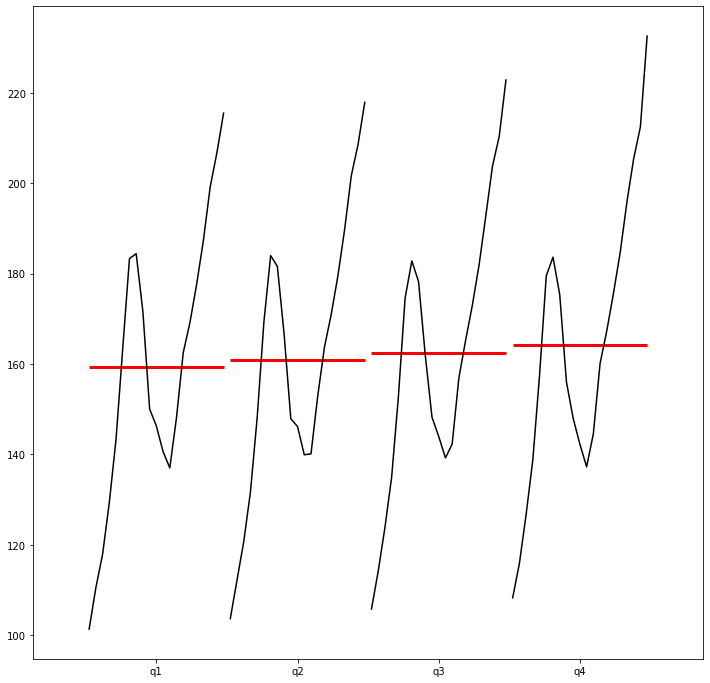

In [111]:
dfq = df[target_index].resample(rule='Q').mean()
quarter_plot(dfq);

In [112]:
#ARIMA orders

In [113]:
from pmdarima import auto_arima

In [114]:
stepwise_fit=auto_arima(df[target_index],start_p=0, start_q=0, max_p=6, max_q=3, seasonal = False, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=167.282, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=169.249, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=169.250, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=165.445, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=171.249, Time=0.04 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.170 seconds


In [115]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -81.723
Date:                Mon, 04 Oct 2021   AIC                            165.445
Time:                        14:46:13   BIC                            168.967
Sample:                             0   HQIC                           166.862
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1126      0.005     24.657      0.000       0.104       0.122
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               662.81
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             1.18
Prob(H) (two-sided):                  0.45   Kurtosis:                        10.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [118]:
#ARMA

In [119]:
auto_arima(df[target_index], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -81.723
Date:                Mon, 04 Oct 2021   AIC                            165.445
Time:                        14:46:14   BIC                            168.967
Sample:                             0   HQIC                           166.862
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1126      0.005     24.657      0.000       0.104       0.122
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               662.81
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             1.18
Prob(H) (two-sided):                  0.45   Kurtosis:                        10.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
train = df.iloc[:200]
test = df.iloc[200:]

In [121]:
model=ARMA(train[target_index], order=(0,1,0))

In [122]:
results=model.fit()

In [123]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  CS_HP   No. Observations:                  200
Model:                     ARMA(0, 1)   Log Likelihood                -778.112
Method:                       css-mle   S.D. of innovations             11.724
Date:                Mon, 04 Oct 2021   AIC                           1562.224
Time:                        14:46:14   BIC                           1572.119
Sample:                    01-01-2000   HQIC                          1566.229
                         - 08-01-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         150.4335      1.646     91.370      0.000     147.207     153.660
ma.L1.CS_HP     0.9909      0.016     61.871      0.000       0.959       1.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0092           +0.0000j            1.0092            0.5000
-----------------------------------------------------------------------------
"""

In [124]:
start=len(train)

In [125]:
end=len(train) +len(test)-1

In [126]:
predictions = results.predict(start,end,typ='levels').rename('ARMA (0,1) Prediction')

In [127]:
error=rmse(test[target_index],predictions)

In [128]:
error

55.67099847324856

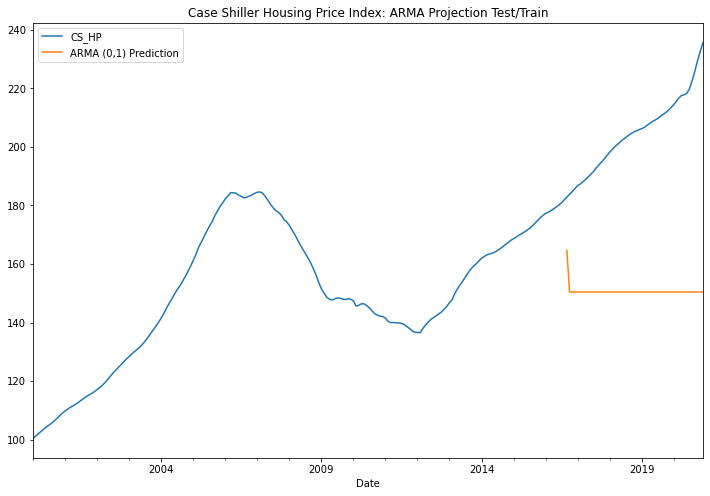

In [129]:
df[target_index].plot(figsize=(12,8), legend=True, title=index_title + ': ARMA Projection Test/Train')
predictions.plot(legend=True)
plt.show()

In [130]:
#ARIMA

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose

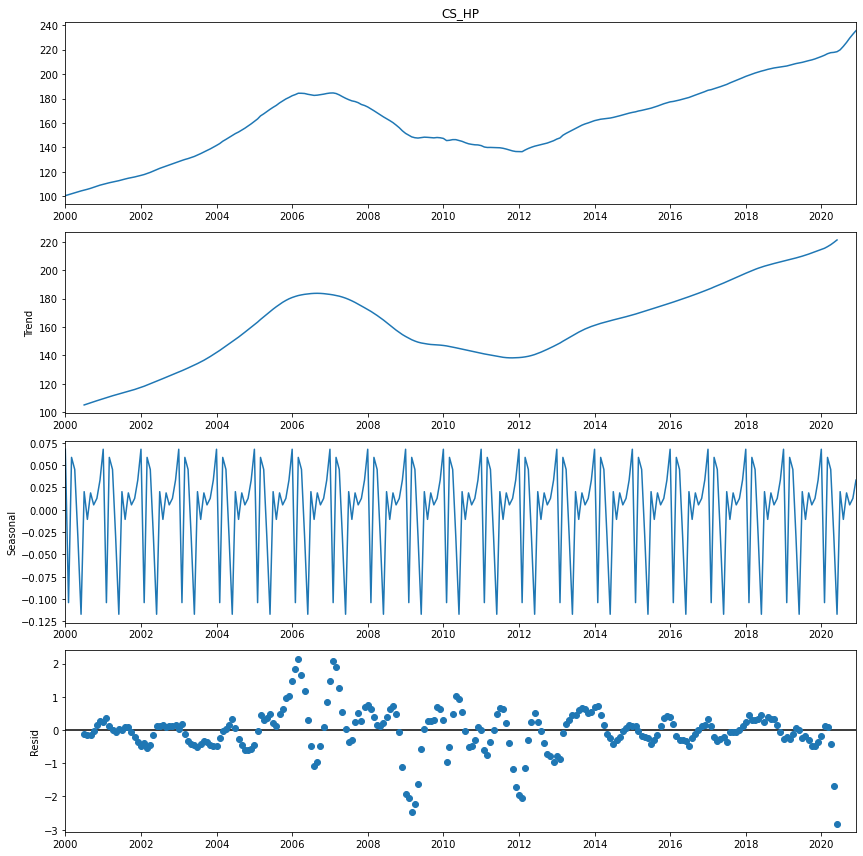

In [132]:
result = seasonal_decompose(df[target_index], model ='add')
result.plot();

In [133]:
auto_arima(df[target_index],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -81.723
Date:                Mon, 04 Oct 2021   AIC                            165.445
Time:                        14:46:15   BIC                            168.967
Sample:                             0   HQIC                           166.862
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1126      0.005     24.657      0.000       0.104       0.122
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               662.81
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             1.18
Prob(H) (two-sided):                  0.45   Kurtosis:                        10.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
df['Diff_1'] =diff(df[target_index], k_diff=2)

In [135]:
adf_test(df['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.576580
p-value                   0.006225
# lags used              12.000000
# observations          237.000000
critical value (1%)      -3.458247
critical value (5%)      -2.873814
critical value (10%)     -2.573311
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


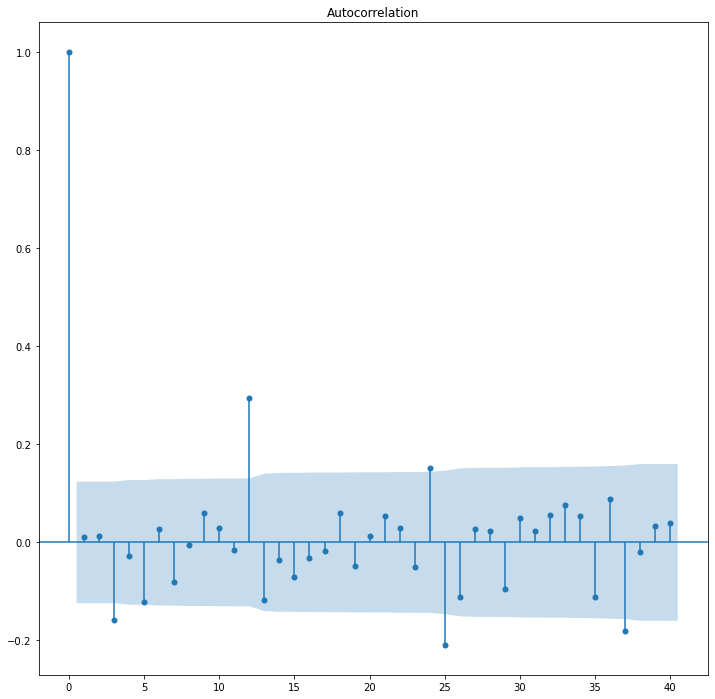

In [136]:
plot_acf(df['Diff_1'].dropna(),lags=40);

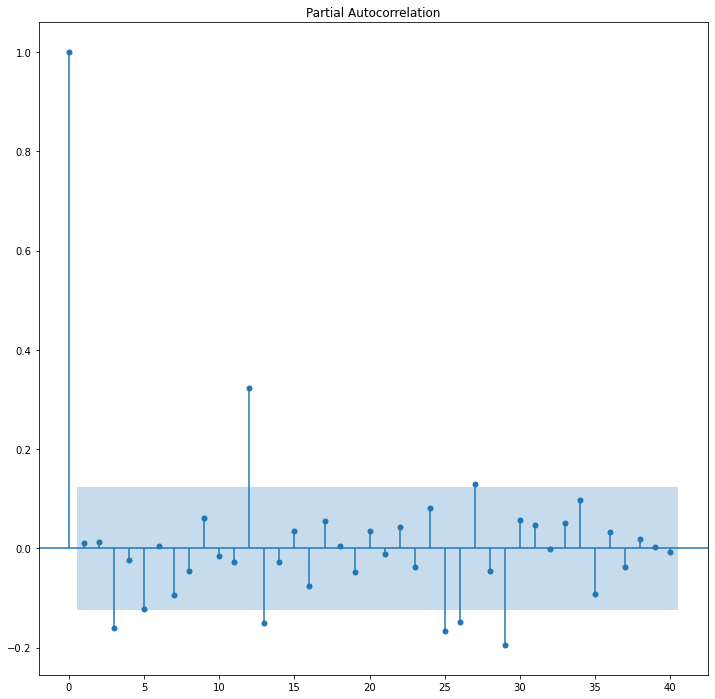

In [137]:
plot_pacf(df['Diff_1'].dropna(),lags=40);

In [138]:
stepwise_fit=auto_arima(df[target_index], start_p=0, start_q=0, max_p=12, max_q=12,
                       seasonal = False, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=167.282, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=169.249, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=169.250, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=165.445, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=171.249, Time=0.05 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.152 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -81.723
Date:                Mon, 04 Oct 2021   AIC                            165.445
Time:                        14:46:16   BIC                            168.967
Sample:                             0   HQIC                           166.862
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1126      0.005     24.657      0.000       0.104       0.122
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               662.81
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             1.18
Prob(H) (two-sided):                  0.45   Kurtosis:                        10.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
train = df.iloc[:200]
test = df.iloc[200:]

In [140]:
model=ARIMA(train[target_index], order=(0,2,0))

In [141]:
results=model.fit()

In [142]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.CS_HP   No. Observations:                  198
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 -70.233
Method:                           css   S.D. of innovations              0.345
Date:                Mon, 04 Oct 2021   AIC                            144.466
Time:                        14:46:16   BIC                            151.043
Sample:                    03-01-2000   HQIC                           147.128
                         - 08-01-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.025      0.046      0.963      -0.047       0.049
==============================================================================
"""

In [143]:
start=len(train)

In [144]:
end=len(train) +len(test)-1

In [145]:
predictions = results.predict(start,end, typ='levels').rename('ARIMA (0,2,0) Prediction')

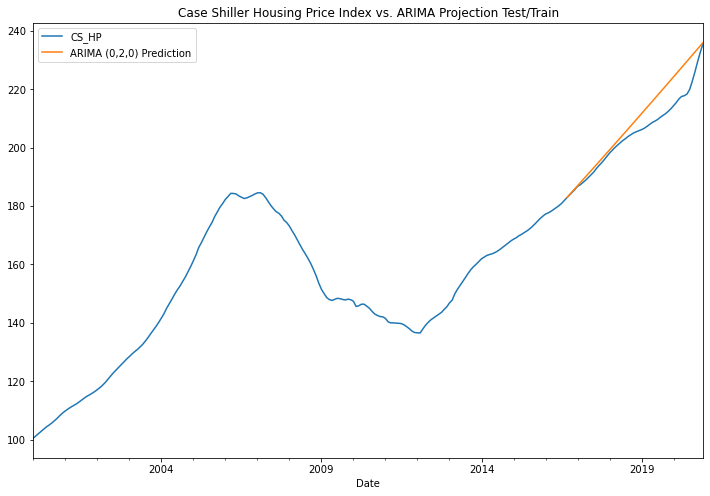

In [146]:
df[target_index].plot(legend=True, figsize=(12,8),title=index_title + ' vs. ARIMA Projection Test/Train')
predictions.plot(legend=True)
plt.show()

In [147]:
error=rmse(test[target_index],predictions)

In [148]:
error

5.841358755013111

In [149]:
#FORECAST

In [150]:
model=ARIMA(df[target_index], order=(0,2,0))

In [151]:
results=model.fit()

In [152]:
fcast=results.predict(start=len(df), end=len(df)+24,typ='levels').rename('ARIMA(0,2,0)')

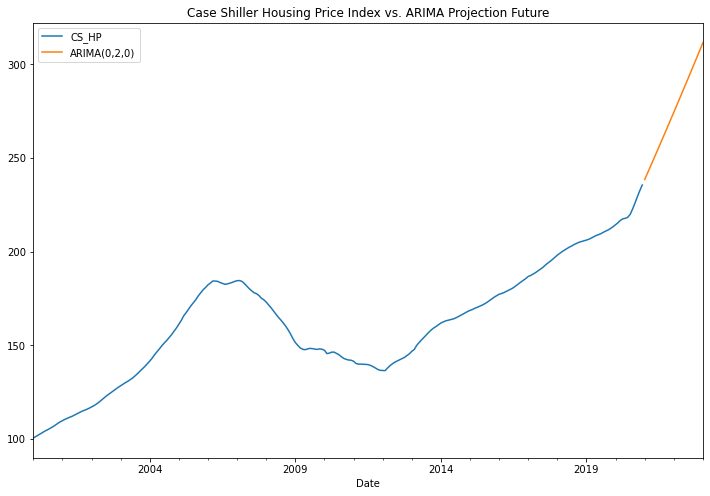

In [153]:
df[target_index].plot(legend=True, figsize=(12,8),title=index_title + ' vs. ARIMA Projection Future')
fcast.plot(legend=True);

In [154]:
#SARIMA Models

In [155]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [156]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [157]:
auto_arima(df[target_index], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  252
Model:             SARIMAX(0, 2, 0)x(1, 0, 0, 12)   Log Likelihood                 -69.305
Date:                            Mon, 04 Oct 2021   AIC                            142.609
Time:                                    14:46:19   BIC                            149.652
Sample:                                         0   HQIC                           145.444
                                            - 252                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3210      0.044      7.378      0.000       0.236       0.406
sigma2         0.1014      0.004     24.890      0.000       0.093       0.109
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               687.10
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.89
Prob(H) (two-sided):                  0.20   Kurtosis:                        10.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
train = df.iloc[:200]
test = df.iloc[200:]

In [159]:
model=SARIMAX(df[target_index], order=(0,3,0), seasonal_order=(1,0,0,12))

In [160]:
results=model.fit()

results.summary()

In [161]:
start=len(train)

In [162]:
end=len(train) +len(test)-1

In [163]:
predictions=results.predict(start, end,typ='levels').rename('SARIMA Predictions')

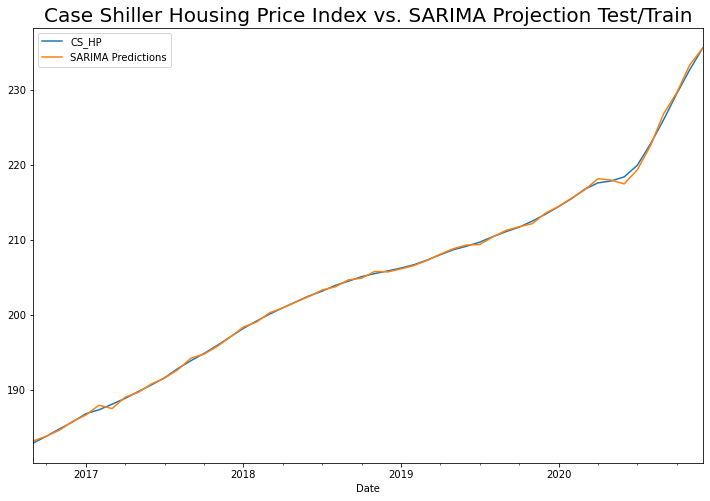

In [164]:
test[target_index].plot(legend=True, figsize=(12,8))
plt.title(index_title + ' vs. SARIMA Projection Test/Train', fontdict = {'fontsize' : 20})
predictions.plot(legend=True)
plt.savefig('image1.jpg');

In [165]:
error

5.841358755013111

In [166]:
#Forecast

In [167]:
model= SARIMAX(df[target_index], order=(0,3,0), seasonal_order=(1,0,0,12))
results=model.fit()

In [168]:
fcast= results.predict(start=len(df), end=len(df)+35,typ='levels').rename('SARIMA FORECAST')

In [169]:
len(fcast)

36

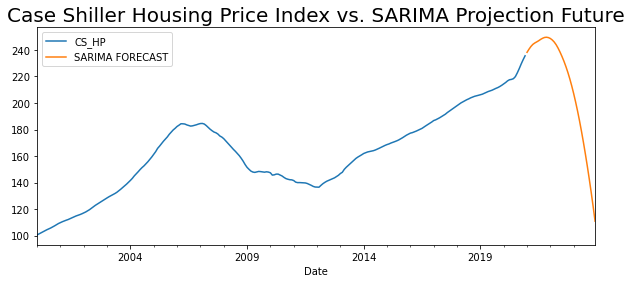

In [170]:
df[target_index].plot(legend=True, figsize=(10,4))
plt.title(index_title + ' vs. SARIMA Projection Future', fontdict = {'fontsize' : 20})
fcast.plot(legend=True)
plt.savefig('image2.jpg');

In [171]:
fcast

2021-01-01    238.221163
2021-02-01    240.553589
2021-03-01    242.624365
2021-04-01    244.215997
2021-05-01    245.266395
2021-06-01    246.096291
2021-07-01    246.965428
2021-08-01    247.982554
2021-09-01    248.813345
2021-10-01    249.415917
2021-11-01    249.590780
2021-12-01    249.333157
2022-01-01    248.642373
2022-02-01    247.512219
2022-03-01    245.958892
2022-04-01    243.902487
2022-05-01    241.320194
2022-06-01    238.329845
2022-07-01    235.026867
2022-08-01    231.451214
2022-09-01    227.480057
2022-10-01    223.098010
2022-11-01    218.231782
2022-12-01    212.879618
2023-01-01    207.041270
2023-02-01    200.714456
2023-03-01    193.905129
2023-04-01    186.583930
2023-05-01    178.742480
2023-06-01    170.424070
2023-07-01    161.663758
2023-08-01    152.476222
2023-09-01    142.816338
2023-10-01    132.678451
2023-11-01    122.035636
2023-12-01    110.887248
Freq: MS, Name: SARIMA FORECAST, dtype: float64

In [172]:
### Auto-ARIMA

In [173]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df[target_index], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=171.249, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=167.282, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=169.249, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=169.250, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=165.445, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.197 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -81.723
Date:                Mon, 04 Oct 2021   AIC                            165.445
Time:                        14:46:20   BIC                            168.967
Sample:                             0   HQIC                           166.862
                                - 252                                         
Co

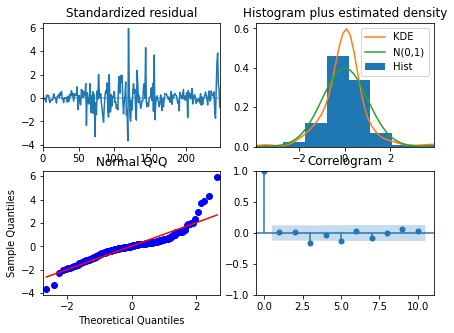

In [174]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [175]:
df[target_index]

Date
2000-01-01    100.552
2000-02-01    101.339
2000-03-01    102.127
2000-04-01    102.922
2000-05-01    103.677
               ...   
2020-08-01    222.735
2020-09-01    225.954
2020-10-01    229.442
2020-11-01    232.656
2020-12-01    235.583
Freq: MS, Name: CS_HP, Length: 252, dtype: float64

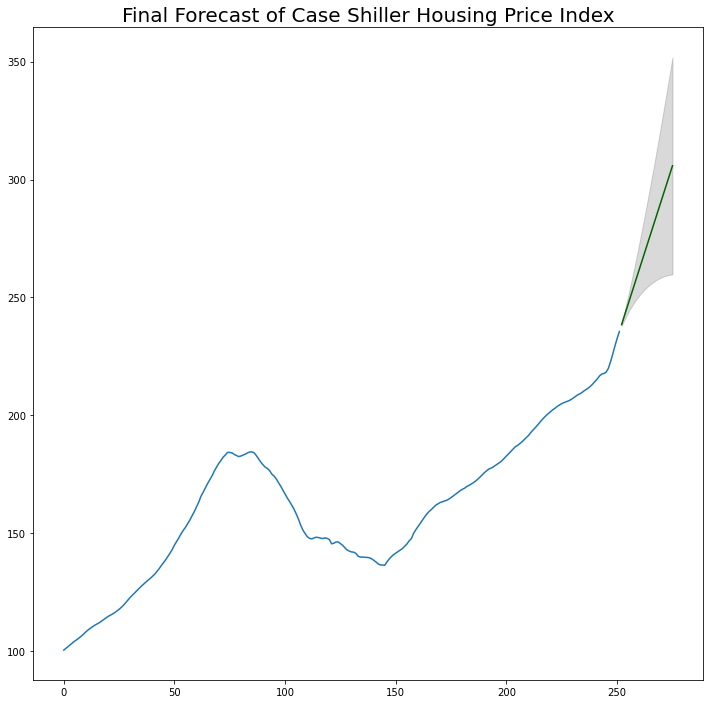

In [176]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df[target_index]), len(df[target_index])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

df.reset_index(inplace=True)

# Plot
plt.plot(df[target_index])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of " + index_title,fontdict = {'fontsize' : 20})
plt.savefig('image3.jpg');

In [177]:
fc_series.to_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/CS_HP.csv', header=False)

In [178]:
###Keras

In [179]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [180]:
from keras.models import Sequential
from keras.layers import Dense

In [181]:
model = Sequential()
# 4 Neurons, expecting only 1 feature with input_dim=1
model.add(Dense(4, input_dim=1, activation='relu'))
# 4 Neurons (Play around with this number!)
model.add(Dense(4, activation='relu'))
# One final output of y, so only 1 neuron
model.add(Dense(1, activation='linear'))
# Compil the layers
model.compile(loss='mse', optimizer='adam')

In [182]:
df=df.reset_index()

In [183]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [184]:
model.fit(df.index, df[target_index], epochs=500, verbose=1)

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 27074.5000
Epoch 2/500
8/8 [==============================] - 0s 855us/step - loss: 27071.9082
Epoch 3/500
8/8 [==============================] - 0s 1ms/step - loss: 27069.3340
Epoch 4/500
8/8 [==============================] - 0s 1ms/step - loss: 27066.7383
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 27064.1562
Epoch 6/500
8/8 [==============================] - 0s 997us/step - loss: 27061.5684
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 27058.9844
Epoch 8/500
8/8 [==============================] - 0s 997us/step - loss: 27056.4121
Epoch 9/500
8/8 [==============================] - 0s 997us/step - loss: 27053.8164
Epoch 10/500
8/8 [==============================] - 0s 997us/step - loss: 27051.2266
Epoch 11/500
8/8 [==============================] - 0s 1ms/step - loss: 27048.6367
Epoch 12/500
8/8 [==============================] - 0s 2ms/step - loss: 27046.0762
Epo

8/8 [==============================] - 0s 997us/step - loss: 26832.2578
Epoch 96/500
8/8 [==============================] - 0s 855us/step - loss: 26829.6816
Epoch 97/500
8/8 [==============================] - 0s 1000us/step - loss: 26827.1211
Epoch 98/500
8/8 [==============================] - 0s 997us/step - loss: 26824.5703
Epoch 99/500
8/8 [==============================] - 0s 997us/step - loss: 26821.9766
Epoch 100/500
8/8 [==============================] - 0s 1ms/step - loss: 26819.4121
Epoch 101/500
8/8 [==============================] - 0s 1ms/step - loss: 26816.8477
Epoch 102/500
8/8 [==============================] - 0s 997us/step - loss: 26814.2676
Epoch 103/500
8/8 [==============================] - 0s 855us/step - loss: 26811.7227
Epoch 104/500
8/8 [==============================] - 0s 1ms/step - loss: 26809.1406
Epoch 105/500
8/8 [==============================] - 0s 997us/step - loss: 26806.5859
Epoch 106/500
8/8 [==============================] - 0s 1ms/step - loss: 2680

8/8 [==============================] - 0s 997us/step - loss: 26586.4883
Epoch 192/500
8/8 [==============================] - 0s 997us/step - loss: 26583.9531
Epoch 193/500
8/8 [==============================] - 0s 997us/step - loss: 26581.3848
Epoch 194/500
8/8 [==============================] - 0s 1ms/step - loss: 26578.8418
Epoch 195/500
8/8 [==============================] - 0s 997us/step - loss: 26576.2871
Epoch 196/500
8/8 [==============================] - 0s 1ms/step - loss: 26573.7461
Epoch 197/500
8/8 [==============================] - 0s 997us/step - loss: 26571.1836
Epoch 198/500
8/8 [==============================] - 0s 997us/step - loss: 26568.6289
Epoch 199/500
8/8 [==============================] - 0s 997us/step - loss: 26566.1035
Epoch 200/500
8/8 [==============================] - 0s 997us/step - loss: 26563.5332
Epoch 201/500
8/8 [==============================] - 0s 997us/step - loss: 26560.9863
Epoch 202/500
8/8 [==============================] - 0s 1ms/step - loss:

Epoch 287/500
8/8 [==============================] - 0s 997us/step - loss: 26342.2070
Epoch 288/500
8/8 [==============================] - 0s 997us/step - loss: 26339.6582
Epoch 289/500
8/8 [==============================] - 0s 1ms/step - loss: 26337.1230
Epoch 290/500
8/8 [==============================] - 0s 1ms/step - loss: 26334.5801
Epoch 291/500
8/8 [==============================] - 0s 997us/step - loss: 26332.0488
Epoch 292/500
8/8 [==============================] - 0s 997us/step - loss: 26329.5137
Epoch 293/500
8/8 [==============================] - 0s 997us/step - loss: 26326.9863
Epoch 294/500
8/8 [==============================] - 0s 997us/step - loss: 26324.4414
Epoch 295/500
8/8 [==============================] - 0s 997us/step - loss: 26321.9160
Epoch 296/500
8/8 [==============================] - 0s 997us/step - loss: 26319.3652
Epoch 297/500
8/8 [==============================] - 0s 1ms/step - loss: 26316.8359
Epoch 298/500
8/8 [==============================] - 0s 998u

8/8 [==============================] - 0s 1ms/step - loss: 26101.8223
Epoch 383/500
8/8 [==============================] - 0s 997us/step - loss: 26099.2969
Epoch 384/500
8/8 [==============================] - 0s 997us/step - loss: 26096.7734
Epoch 385/500
8/8 [==============================] - 0s 1ms/step - loss: 26094.2500
Epoch 386/500
8/8 [==============================] - 0s 1ms/step - loss: 26091.7188
Epoch 387/500
8/8 [==============================] - 0s 997us/step - loss: 26089.2227
Epoch 388/500
8/8 [==============================] - 0s 997us/step - loss: 26086.6855
Epoch 389/500
8/8 [==============================] - 0s 1ms/step - loss: 26084.1543
Epoch 390/500
8/8 [==============================] - 0s 997us/step - loss: 26081.6309
Epoch 391/500
8/8 [==============================] - 0s 997us/step - loss: 26079.1152
Epoch 392/500
8/8 [==============================] - 0s 997us/step - loss: 26076.5938
Epoch 393/500
8/8 [==============================] - 0s 1ms/step - loss: 260

8/8 [==============================] - 0s 998us/step - loss: 25860.2148
Epoch 479/500
8/8 [==============================] - 0s 998us/step - loss: 25857.7109
Epoch 480/500
8/8 [==============================] - 0s 1ms/step - loss: 25855.1992
Epoch 481/500
8/8 [==============================] - 0s 1ms/step - loss: 25852.6973
Epoch 482/500
8/8 [==============================] - 0s 1ms/step - loss: 25850.1777
Epoch 483/500
8/8 [==============================] - 0s 1ms/step - loss: 25847.6855
Epoch 484/500
8/8 [==============================] - 0s 1ms/step - loss: 25845.1406
Epoch 485/500
8/8 [==============================] - 0s 1ms/step - loss: 25842.6602
Epoch 486/500
8/8 [==============================] - 0s 1ms/step - loss: 25840.1426
Epoch 487/500
8/8 [==============================] - 0s 997us/step - loss: 25837.6309
Epoch 488/500
8/8 [==============================] - 0s 1ms/step - loss: 25835.1309
Epoch 489/500
8/8 [==============================] - 0s 997us/step - loss: 25832.611

In [185]:
x_for_predictions = np.linspace(0,252,1000)

In [186]:
y_predicted = model.predict(x_for_predictions)

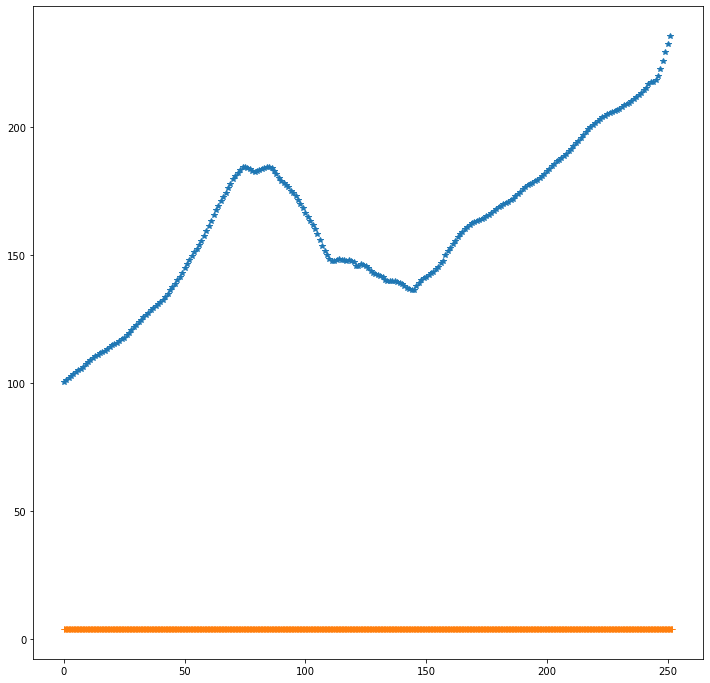

In [187]:
# Original X and Y
plt.plot(df.index, df[target_index],'*')
# Our Model's prediction Line
plt.plot(x_for_predictions,y_predicted,'+')

In [188]:
# start full Keras

In [189]:
df = pd.read_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/time_series_dataframe.csv', index_col=1,parse_dates=True)

In [190]:
df=df.reset_index()

In [191]:
df.drop(labels=(['Date','Unnamed: 0','UNEMPLOY','CS_HPA_20_cities','LF_Part','Y10_CMT','Y30_fixed_mortgage_rate', 'UNEMPLOY_adj','LF_Part_adj']),axis=1,inplace=True)

In [192]:
train_len = len(df)-36

In [193]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]

In [194]:
from sklearn.preprocessing import MinMaxScaler

In [195]:
scaler = MinMaxScaler()

In [196]:
scaler.fit(train)

MinMaxScaler()

In [197]:
scaled_train = scaler.transform(train)

In [198]:
scaled_test = scaler.transform(test)

In [199]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [200]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [201]:
n_input=12
n_features =1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [202]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [203]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [204]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
204/204 [==============================] - 1s 2ms/step - loss: 0.0263
Epoch 2/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 3/30
204/204 [==============================] - 1s 2ms/step - loss: 0.0027
Epoch 4/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 5/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/30
204/204 [==============================] - 0s 2ms/step - loss: 8.1424e-04
Epoch 7/30
204/204 [==============================] - 0s 2ms/step - loss: 9.8875e-04
Epoch 8/30
204/204 [==============================] - 0s 2ms/step - loss: 6.4227e-04
Epoch 9/30
204/204 [==============================] - 1s 3ms/step - loss: 6.4286e-04
Epoch 10/30
204/204 [==============================] - 0s 2ms/step - loss: 4.8039e-04
Epoch 11/30
204/204 [==============================] - 0s 2ms/step - loss: 4.0096e-04
Epoch 12/30
204/204 [==============================] - 0s 2ms/step - loss: 4.3065e-

In [205]:
model.history.history.keys()

dict_keys(['loss'])

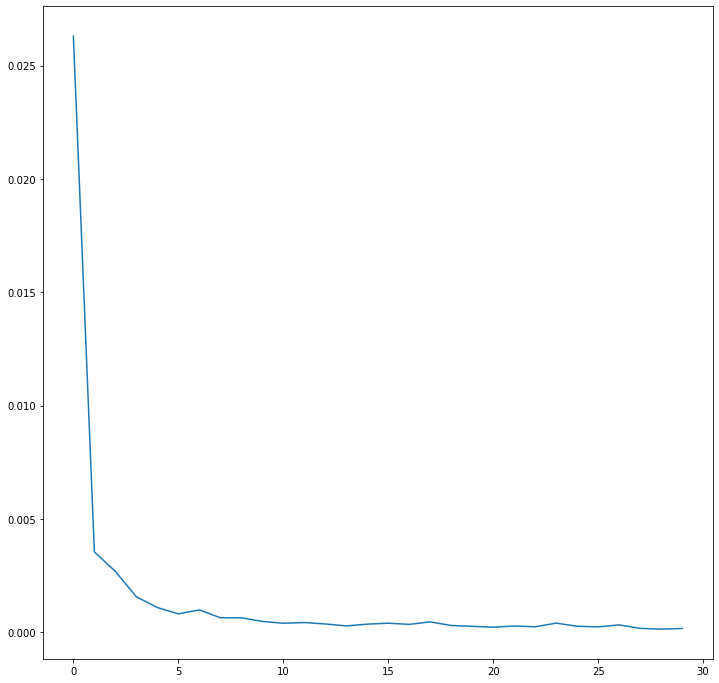

In [206]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.show()

In [207]:
first_eval_batch = scaled_train[-12:]

In [208]:
first_eval_batch

array([[0.89376743],
       [0.8992195 ],
       [0.90694155],
       [0.91504711],
       [0.92446904],
       [0.93365258],
       [0.94347876],
       [0.95613462],
       [0.96703878],
       [0.97706189],
       [0.98810079],
       [1.        ]])

In [209]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [210]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [211]:
true_predictions = scaler.inverse_transform(test_predictions)

In [212]:
true_predictions

array([[195.96063032],
       [196.03126343],
       [195.65524547],
       [194.93710861],
       [193.9399816 ],
       [192.72410068],
       [191.33596995],
       [189.69463997],
       [187.85565457],
       [185.84711636],
       [183.68878396],
       [181.41602856],
       [179.04587157],
       [176.58931942],
       [174.08514181],
       [171.55946317],
       [169.03545792],
       [166.53108479],
       [164.06721228],
       [161.66157485],
       [159.33083164],
       [157.09053194],
       [154.95000877],
       [152.92026854],
       [151.00858561],
       [149.21663337],
       [147.54952112],
       [146.00824656],
       [144.59323811],
       [143.30497018],
       [142.13921041],
       [141.09394903],
       [140.1632429 ],
       [139.346655  ],
       [138.63600526],
       [138.02562947]])

In [213]:
test['Predictions'] = true_predictions

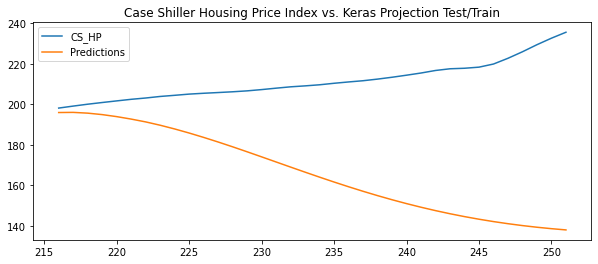

In [214]:
test.plot(figsize=(10,4),title=index_title + ' vs. Keras Projection Test/Train')
plt.show()

In [215]:
error=rmse(test[target_index],test['Predictions'])

In [216]:
print(error)

53.397265884528295


In [217]:
### Keras projection

In [218]:
train_len = len(df)

In [219]:
train = df.iloc[:train_len]

In [220]:
scaler.fit(train)

MinMaxScaler()

In [221]:
scaled_train = scaler.transform(train)

In [222]:
n_input=12
n_features =1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [223]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [224]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [225]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0134
Epoch 2/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0020
Epoch 3/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 4/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 5/30
240/240 [==============================] - 1s 2ms/step - loss: 8.1610e-04
Epoch 6/30
240/240 [==============================] - 1s 2ms/step - loss: 9.0182e-04
Epoch 7/30
240/240 [==============================] - 1s 2ms/step - loss: 4.5632e-04
Epoch 8/30
240/240 [==============================] - 1s 2ms/step - loss: 3.7906e-04
Epoch 9/30
240/240 [==============================] - 1s 2ms/step - loss: 3.6025e-04
Epoch 10/30
240/240 [==============================] - 1s 2ms/step - loss: 3.8468e-04
Epoch 11/30
240/240 [==============================] - 1s 2ms/step - loss: 3.9265e-04
Epoch 12/30
240/240 [==============================] - 1s 2ms/step - loss: 2.91

In [226]:
model.history.history.keys()

dict_keys(['loss'])

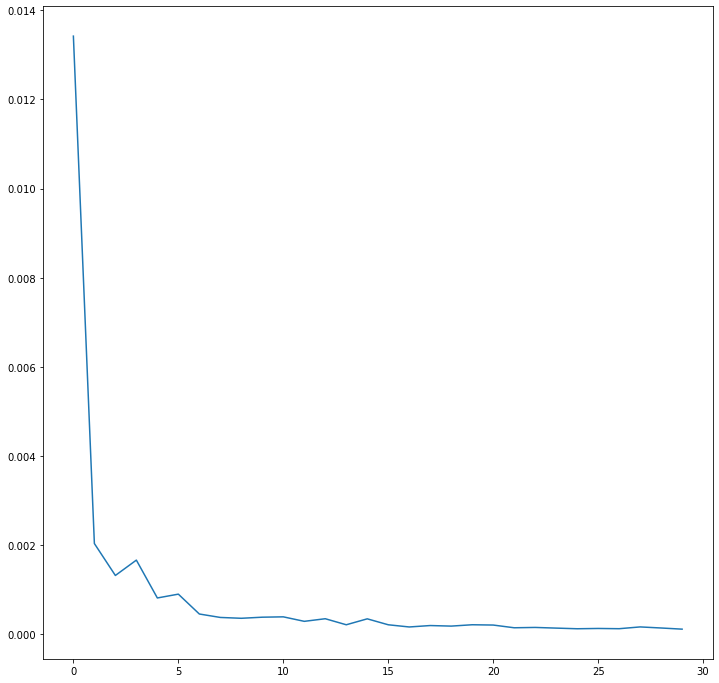

In [227]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [228]:
first_eval_batch = scaled_train[-12:]

In [229]:
first_eval_batch

array([[0.84302864],
       [0.85098977],
       [0.86026912],
       [0.86648251],
       [0.86837837],
       [0.87242189],
       [0.88384889],
       [0.90485148],
       [0.92869045],
       [0.95452155],
       [0.9783235 ],
       [1.        ]])

In [230]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [231]:
future_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(36):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    future_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [232]:
true_predictions = scaler.inverse_transform(test_predictions)

In [233]:
projections=pd.DataFrame(true_predictions)

In [234]:
projections.index = np.arange(252, 252+36)

In [235]:
projections=projections.rename(columns={0: 'CS_HP:Proj.'})

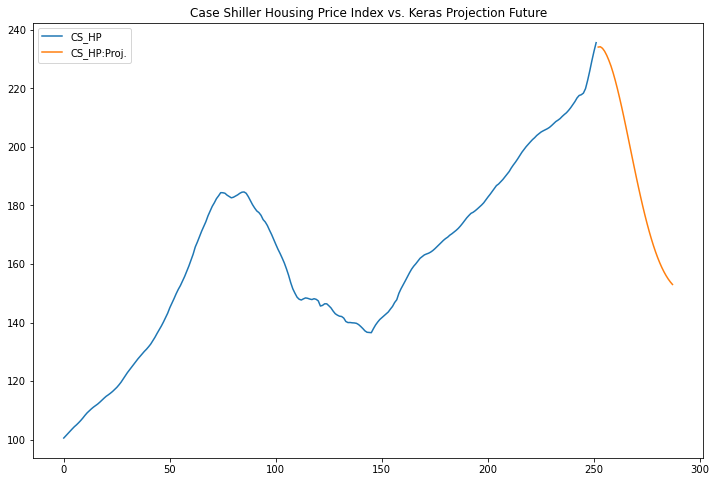

In [236]:
train['CS_HP'].plot(figsize=(12,8), legend=True,title=index_title + ' vs. Keras Projection Future')
projections['CS_HP:Proj.'].plot(legend=True)
plt.show()